### Pós-graduação em Ciência de Dados e Machine Learning

#### Disciplina: **Introdução a Redes Neurais**

#### Projeto Final para disciplina Introdução a Redes Neurais

<BR>
    
### **Integrantes**:
#### Nome:  Gustavo Gomes Balbino
#### RA: 52400106

#### Nome:  Gustavo Lopes Urio Fonseca
#### RA: 52400113
---

# Classificação de Tumores de Mama em Imagens de Ultrassom

**Objetivos**  
1. **Pré-processamento**: usar máscaras para recortar região de tumor.  
2. **Modelagem**: ResNet50 pré-treinada + blocos customizados (PDFBlock + SEBlock).  
3. **Treino**: otimizar usando loss binária, métricas AUC e acurácia.  
4. **Avaliação**: matriz de confusão, AUC e relatório de resultados.

**Métricas de Sucesso**  
- Acurácia ≥ X%  
- AUC ≥ Y%  
- Boa separação das classes (confusion matrix bem balanceada)

## 1. Introdução

O câncer de mama é uma das principais causas de morte por câncer em mulheres. O diagnóstico precoce é fundamental para o sucesso do tratamento. Dentre os exames de imagem utilizados, o ultrassom é amplamente aplicado, principalmente para distinguir tumores benignos de malignos. Este projeto tem como objetivo construir um modelo baseado em deep learning capaz de classificar tumores a partir de imagens de ultrassom.


## 2. Objetivos do Projeto

- Realizar o pré-processamento das imagens utilizando as máscaras de segmentação para destacar a região de interesse.

- Desenvolver um modelo de classificação utilizando uma rede EfficientNetB0 pré-treinada, complementada com blocos customizados (PDFBlock e SEBlock).

- Treinar e avaliar o modelo utilizando métricas como AUC e acurácia.

- Analisar o desempenho através de matriz de confusão e relatório de classificação.


---
## 3. Metodologia

Nesta seção descrevemos todo o pipeline, desde o ambiente e bibliotecas até a modelagem e treinamento.

In [ ]:
import gc
import tensorflow as tf

# Limpar sessão TensorFlow
tf.keras.backend.clear_session()

# Coletar lixo do Python
gc.collect()


2025-04-29 19:32:46.030208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745965966.042841  247347 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745965966.046731  247347 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745965966.057816  247347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745965966.057893  247347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745965966.057896  247347 computation_placer.cc:177] computation placer alr

0

### 3.1 Ambiente e Bibliotecas

- Python 3.9  
- TensorFlow / Keras  
- scikit-learn, pandas, numpy, matplotlib  
- Execução com suporte a GPU (RTX 2060 ou similar)

In [ ]:
import os
import glob

# Removido: os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as skshuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, Input, Model
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


print("Dispositivos visíveis:", tf.config.list_physical_devices('GPU'))
print("Versão do TensorFlow:", tf.__version__)


Dispositivos visíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Versão do TensorFlow: 2.19.0


### 3.2 Exploração dos Dados

O dataset possui 811 imagens e 811 máscaras, divididos em:
- Benignos: 358  
- Malignos: 453  

In [ ]:
df = pd.read_csv('dataset.csv', sep=',')
df.head(10)

,Level,Name,Type,Description,File Count
0,0,.,directory,Root directory,2
1,1,images,directory,Contains all ultrasound images,811
2,1,masks,directory,Contains corresponding segmentation masks,811
3,1,Benign,directory,Contains benign tumor data,2
4,2,Benign/images,directory,Ultrasound images of benign tumors,358
5,2,Benign/masks,directory,Segmentation masks for benign tumors,358
6,1,Malignant,directory,Contains malignant tumor data,2
7,2,Malignant/images,directory,Ultrasound images of malignant tumors,453
8,2,Malignant/masks,directory,Segmentation masks for malignant tumors,453


##### Abaixo vamos listar imagens, máscaras e labels

In [ ]:
BASE_DIR = "BUS_UC/BUS_UC/BUS_UC"
IMG_PATTERN = "*.png"

# diretórios
dirs = {
    0: (os.path.join(BASE_DIR, "Benign",    "images"),
        os.path.join(BASE_DIR, "Benign",    "masks")),
    1: (os.path.join(BASE_DIR, "Malignant", "images"),
        os.path.join(BASE_DIR, "Malignant", "masks")),
}

all_images, all_masks, all_labels = [], [], []
for label, (img_dir, mask_dir) in dirs.items():
    imgs  = sorted(glob.glob(os.path.join(img_dir,  IMG_PATTERN)))
    masks = sorted(glob.glob(os.path.join(mask_dir, IMG_PATTERN)))
    all_images += imgs
    all_masks  += masks
    all_labels += [label] * len(imgs)

print(f"Total: {len(all_images)} imagens, {len(all_masks)} máscaras")
print("Distribuição:", pd.Series(all_labels).value_counts().to_dict())

Total: 811 imagens, 811 máscaras
Distribuição: {1: 453, 0: 358}


### 3.4 Divisão dos Dados

- Treino: 70% (567)  
- Validação: 15% (122)  
- Teste: 15% (122)

In [ ]:
imgs, masks, labs = skshuffle(all_images, all_masks, all_labels, random_state=42)
X_train, X_rem, M_train, M_rem, y_train, y_rem = train_test_split(
    imgs, masks, labs,
    test_size=0.30, stratify=labs, random_state=42
)
X_val, X_test, M_val, M_test, y_val, y_test = train_test_split(
    X_rem, M_rem, y_rem,
    test_size=0.50, stratify=y_rem, random_state=42
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 567 | Val: 122 | Test: 122


### 3.3 Pré-processamento e Aumentação

- Normalização para [0,1]  
- Recorte da região de interesse usando máscaras  
- Aumentação aplicada apenas no treino: flips, brilho, contraste e saturação aleatórios  

In [ ]:
IMG_SIZE = (224, 224)

def parse_image_mask(img_path, mask_path, label):
    # lê e normaliza imagem
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE) / 255.0

    # lê máscara e redimensiona
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE)

    # aplica máscara
    img = img * mask

    # AUGMENTAÇÃO APENAS NO TREINO
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_flip_left_right(img)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_flip_up_down(img)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, max_delta=0.15)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_saturation(img, lower=0.8, upper=1.2)

    return img, label

### 3.5 Criação do Pipeline com `tf.data`

Construção dos `Dataset` e `DataLoader` para treino, validação e teste.

In [ ]:
def make_dataset(imgs, masks, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((imgs, masks, labels))
    if shuffle:
        ds = ds.shuffle(len(imgs))
    ds = ds.map(lambda i, m, l: parse_image_mask(i, m, l),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, M_train, y_train)
val_ds = make_dataset(X_val, M_val, y_val, shuffle=False)
test_ds = make_dataset(X_test, M_test, y_test, shuffle=False)

# verificação rápida
for imgs, labs in train_ds.take(1):
    print("Batch imagens:", imgs.shape, "Batch labels:", labs.numpy())

I0000 00:00:1745965968.986928  247347 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4047 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Batch imagens: (16, 224, 224, 3) Batch labels: [1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1]


2025-04-29 19:32:49.525397: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 3.6 Blocos Customizados

Definição de:
- **PDFBlock**: fusão piramidal com convoluções dilatadas  
- **SEBlock**: recalibração channel-wise (Squeeze-and-Excitation)


In [ ]:
class SEBlock(layers.Layer):
    """Squeeze-and-Excitation: recalibra dinamicamente a importância dos canais."""
    def __init__(self, channels, reduction=16, **kwargs):
        super().__init__(**kwargs)
        self.global_pool = layers.GlobalAveragePooling2D()
        self.fc1         = layers.Dense(channels // reduction, activation="relu")
        self.fc2         = layers.Dense(channels,          activation="sigmoid")
        self.reshape     = layers.Reshape((1, 1, channels))
        self.multiply    = layers.Multiply()

    def call(self, x):
        se = self.global_pool(x)      # [B, C]
        se = self.fc1(se)             # [B, C/r]
        se = self.fc2(se)             # [B, C]
        se = self.reshape(se)         # [B, 1, 1, C]
        return self.multiply([x, se])

class PDFBlock(layers.Layer):
    """Pyramid-Dilated Fusion: múltiplas convoluções dilatadas + projeção 1×1."""
    def __init__(self, out_channels, kernel_sizes, dilations, **kwargs):
        super().__init__(**kwargs)
        assert len(kernel_sizes) == len(dilations), "kernel_sizes e dilations devem ter mesmo tamanho"
        self.branches = []
        for k, d in zip(kernel_sizes, dilations):
            self.branches.append(
                layers.Conv2D(
                    filters=out_channels,
                    kernel_size=k,
                    padding="same",
                    dilation_rate=d,
                    activation="relu"
                )
            )
        self.project = layers.Conv2D(filters=out_channels, kernel_size=1, activation="relu")

    def call(self, x):
        feats = [branch(x) for branch in self.branches]
        x_cat = tf.concat(feats, axis=-1)
        return self.project(x_cat)

### 3.7 Arquitetura de Classificação

Backbone: EfficientNetB0 pré-treinado  
→ PDFBlock → SEBlock → GAP → Dense(256) → Dropout(0.5) → Dense(1, sigmoid)


In [ ]:
# 1) Backbone ResNet50 sem top layer, retendo mapa espacial
# Usando EfficientNetB0 como backbone por ser mais leve e rápido
backbone = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3)
)
backbone.trainable = False  # congelado no início

# 2) Construção do grafo
inp = Input(shape=(*IMG_SIZE, 3), name="input_image")
x   = backbone(inp)                            # [B, H', W', C=2048]

# 3) Aplicar PDFBlock (multi‐escala)
x = PDFBlock(
    out_channels=512,
    kernel_sizes=[1, 3, 5, 7],
    dilations=[1, 2, 3, 4]
)(x)  # agora [B, H', W', 512]

# 4) Recalibração de canais via SEBlock
x = SEBlock(channels=512, reduction=16)(x)      # [B, H', W', 512]

# 5) Agregação e cabeça de classificação
x = layers.GlobalAveragePooling2D(name="gap")(x)  # [B, 512]
x = layers.Dense(256, activation="relu", name="fc1")(x)
x = layers.Dropout(0.5, name="dropout")(x)
out = layers.Dense(1, activation="sigmoid", name="output")(x)

model_clf = Model(inputs=inp, outputs=out, name="MobileNetV2_PDF_SE_Clf")

#Penalizar mais os erros
def focal_loss(alpha=0.55, gamma=2.):  
    """
    alpha > 0.5 favorece mais o foco na classe 1 (Malignant).
    """
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    
    return focal_loss_fixed

# 6) Compilação do modelo
model_clf.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(alpha=0.55, gamma=2.),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model_clf.summary()

Model: "MobileNetV2_PDF_SE_Clf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pdf_block (PDFBlock)            │ (None, 7, 7, 512)      │    56,101,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block (SEBlock)              │ (None, 7, 7, 512)      │        33,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,315,844 (230.09 MB)

 Trainable params: 56,266,273 (214.64 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 4. Treinamento

Configuração de callbacks, loss e otimização.


In [ ]:
callbacks_list = [
    callbacks.EarlyStopping(
        monitor="val_auc",
        patience=4,
        mode="max",
        restore_best_weights=True,
        verbose=1
    ),
]

### 4.1 Ajuste de Pesos das Classes

Cálculo de `class_weight` para balancear as classes no treino.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular pesos
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train  # (usa os labels do treino)
)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weights_dict)


{0: np.float64(1.134), 1: np.float64(0.8943217665615142)}


### 4.2 Treino Inicial

Execução do `.fit()` com Focal Loss, Adam e pesos de classe.


In [ ]:
history = model_clf.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks_list,
    class_weight=class_weights_dict
)

Epoch 1/30


I0000 00:00:1745965980.715930  247426 service.cc:152] XLA service 0x7fcaa40039f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745965980.715961  247426 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-04-29 19:33:01.172587: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745965982.911359  247426 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-04-29 19:33:11.043673: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-29 19:33:11.661514: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5233 - auc: 0.5256 - loss: 0.0901

2025-04-29 19:33:26.670108: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-29 19:33:31.028286: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng28{k2=1,k3=0} for conv %cudnn-conv.177 = (f32[1280,512,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[1280,63,7,7]{3,2,1,0} %bitcast.37214, f32[512,63,3,3]{3,2,1,0} %bitcast.39069), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/MobileNetV2_PDF_SE_Clf_1/pdf_block_1/conv2d_2_1/convolution/Conv2DBackpropFilter" source_file="/home/gustavo/projetoFinal-DeepLearning/venv/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operati

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.5240 - auc: 0.5267 - loss: 0.0901

2025-04-29 19:33:46.100930: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 922ms/step - accuracy: 0.5247 - auc: 0.5276 - loss: 0.0901 - val_accuracy: 0.5902 - val_auc: 0.6469 - val_loss: 0.0835
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6347 - auc: 0.6584 - loss: 0.0796 - val_accuracy: 0.5984 - val_auc: 0.6940 - val_loss: 0.0793
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.6623 - auc: 0.7483 - loss: 0.0744 - val_accuracy: 0.5820 - val_auc: 0.6367 - val_loss: 0.0817
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.6907 - auc: 0.7681 - loss: 0.0725 - val_accuracy: 0.6721 - val_auc: 0.7206 - val_loss: 0.0761
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.7261 - auc: 0.7617 - loss: 0.0728 - val_accuracy: 0.6639 - val_auc: 0.7530 - val_loss: 0.0726
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.7796 - auc: 0.8489 - loss: 0.0634 - val_accuracy: 0.5082 - val_auc: 0.6404 - val_loss: 0.0983
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/ste

## 5. Resultados Iniciais

Avaliação do modelo treinado originalmente.


In [ ]:
test_loss, test_acc, test_auc = model_clf.evaluate(test_ds)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC:      {test_auc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5938 - auc: 0.6312 - loss: 0.0839
Test Loss:     0.0835
Test Accuracy: 0.5902
Test AUC:      0.6442


### 5.1 Curvas de Loss e AUC durante o Treino


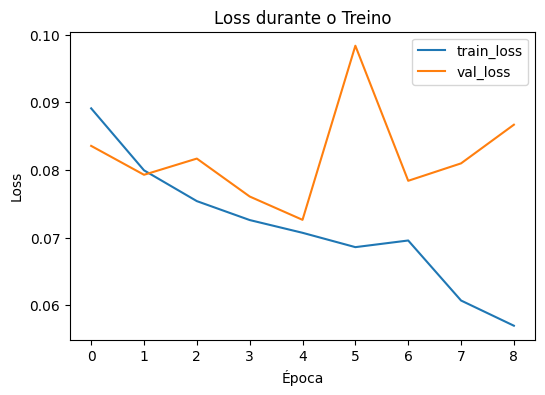

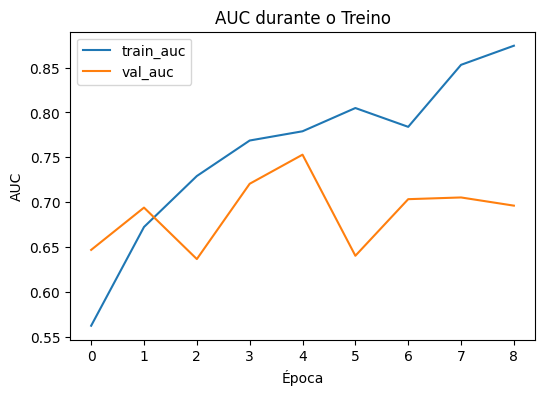

In [ ]:
# 1) Loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"],   label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss durante o Treino")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 2) AUC
plt.figure(figsize=(6,4))
plt.plot(history.history["auc"],     label="train_auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.title("AUC durante o Treino")
plt.xlabel("Época")
plt.ylabel("AUC")
plt.legend()
plt.show()

### 5.2 Avaliação no Conjunto de Teste

- Classification Report  
- Matriz de Confusão


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 648ms/step
              precision    recall  f1-score   support

      Benign       0.55      0.50      0.52        54
   Malignant       0.63      0.68      0.65        68

    accuracy                           0.60       122
   macro avg       0.59      0.59      0.59       122
weighted avg       0.60      0.60      0.60       122



2025-04-29 19:34:36.547066: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


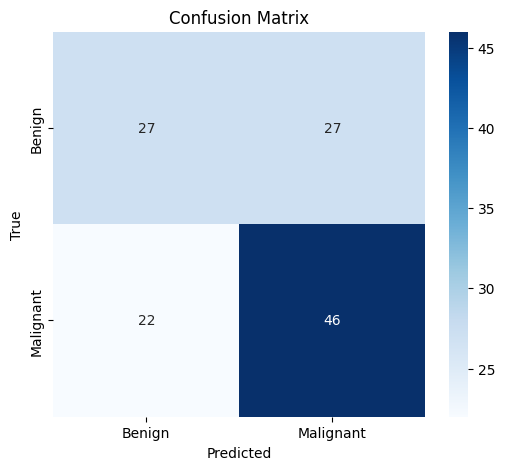

In [ ]:
# Previsões
y_pred_prob = model_clf.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
y_true = np.concatenate([labels.numpy() for imgs, labels in test_ds], axis=0)

# Classification Report
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## 6. Ajuste Fino (Fine-tuning)

Descongelamento dos últimos 30% das camadas do backbone e re-treinamento.


In [ ]:
# Descongelar EfficientNetB0 a partir de 70% das camadas
fine_tune_at = int(len(backbone.layers) * 0.7)

for layer in backbone.layers[fine_tune_at:]:
    layer.trainable = True

# Recompilar o modelo com learning rate menor
model_clf.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)


### 6.1 Treino após Fine-tuning


In [ ]:
# Treinar mais algumas épocas após liberar as camadas
history_finetune = model_clf.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks_list,
    class_weight=class_weights_dict  # Mantém pesos!
)


Epoch 1/5


2025-04-29 19:34:55.817116: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-29 19:34:55.817186: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-29 19:34:56.923807: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-29 19:34:57.533447: W external/local_xla/xla/ts

36/36 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6489 - auc: 0.7012 - loss: 0.6339 - val_accuracy: 0.6148 - val_auc: 0.7367 - val_loss: 0.6108
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.6741 - auc: 0.7590 - loss: 0.6024 - val_accuracy: 0.6148 - val_auc: 0.7166 - val_loss: 0.6114
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.7009 - auc: 0.7629 - loss: 0.5920 - val_accuracy: 0.6311 - val_auc: 0.6923 - val_loss: 0.6200
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.7199 - auc: 0.8058 - loss: 0.5613 - val_accuracy: 0.5820 - val_auc: 0.6859 - val_loss: 0.6208
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.6902 - auc: 0.7840 - loss: 0.5667 - val_accuracy: 0.6148 - val_auc: 0.6857 - val_loss: 0.6246
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


### 6.2 Avaliação no Teste após Fine-tuning


In [ ]:
# Avaliar no conjunto de teste
loss, accuracy, auc = model_clf.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5840 - auc: 0.6049 - loss: 0.6497
Test Loss: 0.6470
Test Accuracy: 0.5820
Test AUC: 0.6382


### 6.3 Matriz de Confusão e Classification Report


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 713ms/step
              precision    recall  f1-score   support

      Benign       0.54      0.39      0.45        54
   Malignant       0.60      0.74      0.66        68

    accuracy                           0.58       122
   macro avg       0.57      0.56      0.56       122
weighted avg       0.57      0.58      0.57       122



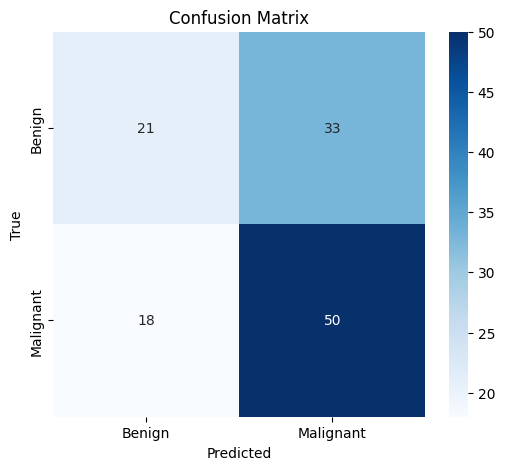

In [ ]:
# Previsões
y_pred_prob = model_clf.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
y_true = np.concatenate([labels.numpy() for imgs, labels in test_ds], axis=0)

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## 7. Análise Crítica

O modelo apresenta recall mais alto para malignos, o que é desejável em diagnóstico precoce, mesmo que a acurácia geral fique em ~60%.


## 8. Conclusões e Recomendações

- Máscaras melhoram o pré-processamento.  
- EfficientNetB0 + PDFBlock/SEBlock extraiu bons recursos.  
- Fine-tuning aumentou recall de malignos (ponto crítico).  

**Recomendações**:  
1. Experimentar ensembling ou outros backbones.  
2. Tuning de hiperparâmetros.  
3. Aumentar o dataset e diversificar augmentations.